# IALP Forecating Analysis

In [2]:
import calendar
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, seasonal_plot, month_plot
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing, ETSModel, seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from src.utils import *
from prophet import Prophet
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "figure.figsize": (7,5), "lines.linewidth": 2})
from src.plotting import *
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm

plt.rcParams['figure.facecolor'] = 'white'





In [96]:
ialp = pd.read_csv("data/processed/IALP_Monthly_Revenue.csv", index_col=0)
ialp = ialp[['Year_Month','Revenue']]
ialp['Year_Month'] = pd.to_datetime(ialp['Year_Month'], format='%Y-%m')
ialp = ialp.set_index('Year_Month').sort_index()
ialp.to_csv("data/processed/IALP_Monthly_Revenue.csv")

In [4]:
ialp["Revenue"] = ialp["Revenue"].replace(0, np.nan)
ialp["Revenue"] = ialp["Revenue"].interpolate(method="linear")  

# EDA 

<Axes: xlabel='Time', ylabel='Revenue'>

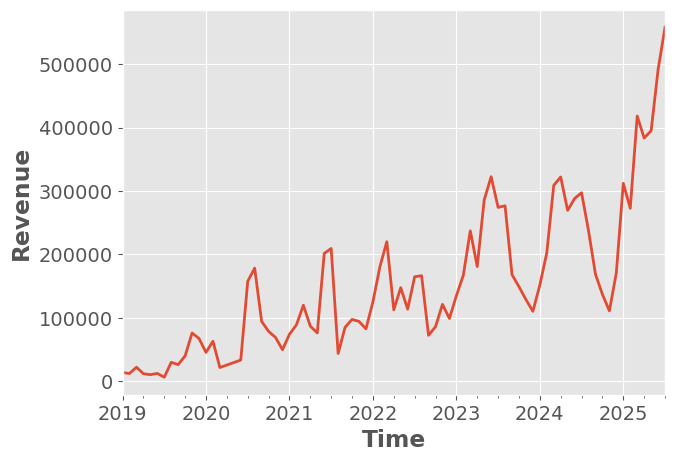

In [5]:
# Visualize the whole dataset
ialp.plot.line(xlabel="Time", ylabel="Revenue", legend=False)

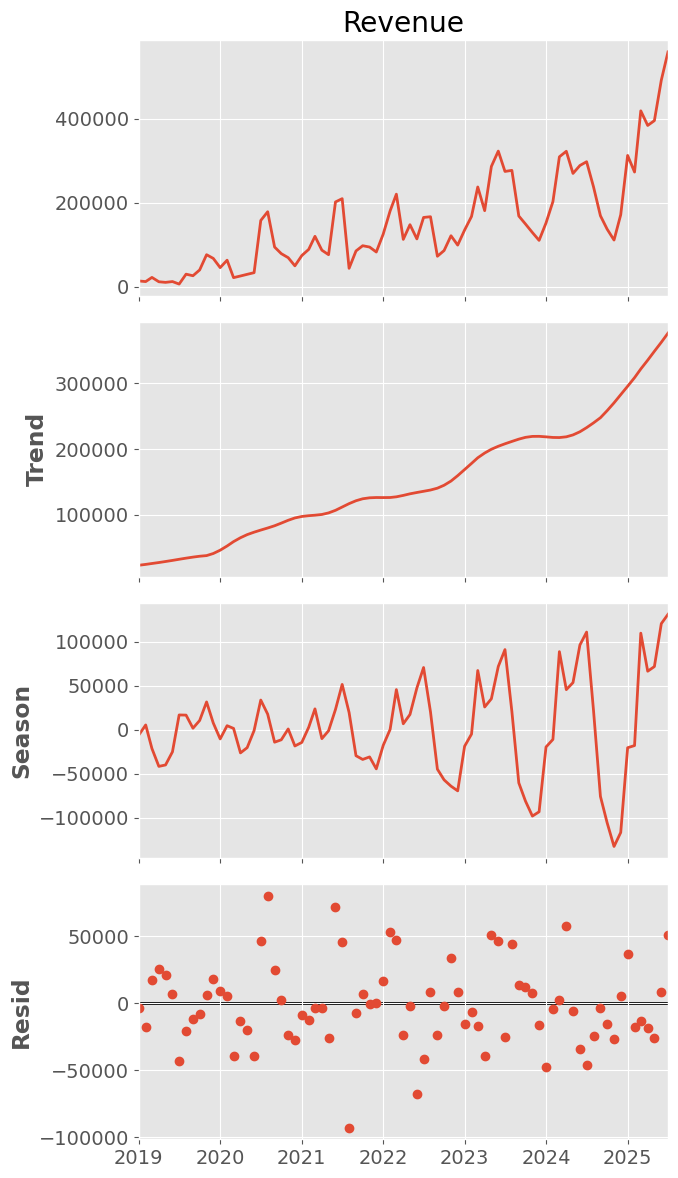

In [6]:
# Decompose the data with STL 
model = STL(ialp["Revenue"], period=12, seasonal=13).fit()
with mpl.rc_context():
    mpl.rc("figure", figsize=(7, 12))
    model.plot()

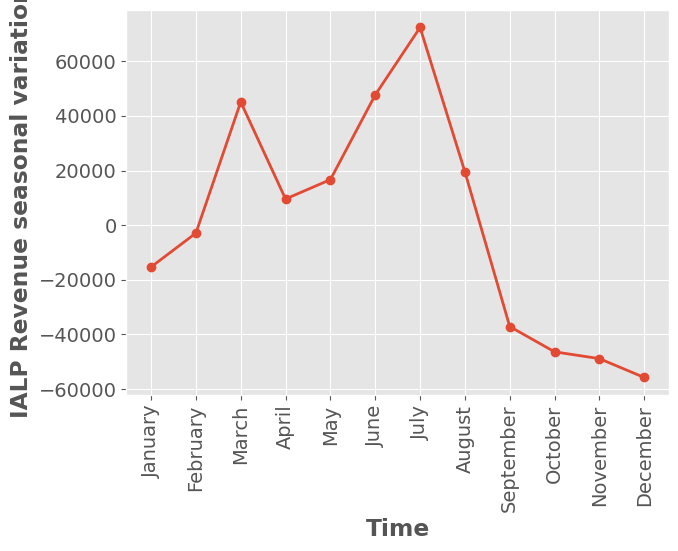

In [7]:
seasonal = model.seasonal.groupby(model.seasonal.index.month).mean()
seasonal.plot.line(xlabel="Time", ylabel="IALP Revenue seasonal variation", marker="o")
plt.xticks(range(1, 13), calendar.month_name[1:], rotation='vertical');

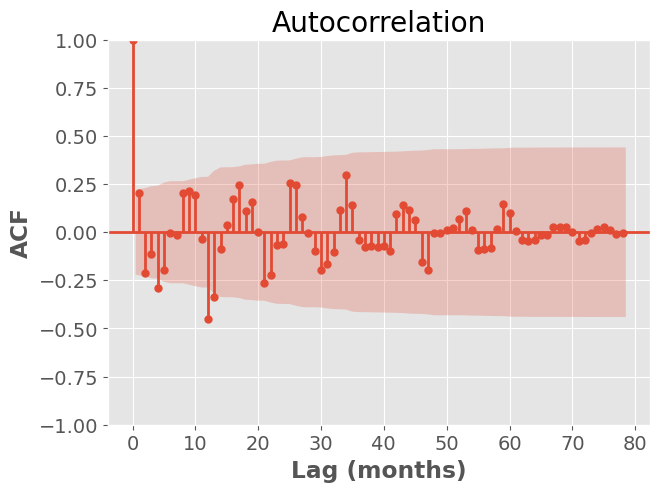

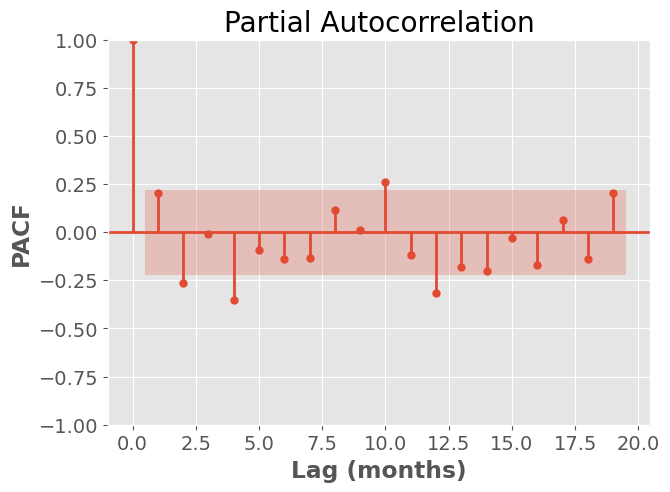

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_fig = plot_acf(model.resid, lags=78)
plt.ylabel("ACF")
plt.xlabel("Lag (months)");
pacf_fig = plot_pacf(model.resid)
plt.ylabel("PACF")
plt.xlabel("Lag (months)");

### The whole data set show obvious trend, seasonality, and signals of autocorrelation.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA

# 假设你的数据叫 df，格式：
df= ialp.copy()

# 1. STL 分解
stl = STL(df["Revenue"], period=12, robust=True)
result = stl.fit()

trend = result.trend
seasonal = result.seasonal
resid = result.resid

# 2. 拟合 ARIMA 模型到 trend
model = ARIMA(trend.dropna(), order=(1,1,1))  # order 可以调优
fit = model.fit()

# 预测未来 12 个月的 trend
n_forecast = 18
forecast_trend = fit.forecast(steps=n_forecast)

# 3. 固定季节性模式
seasonal_pattern = seasonal.groupby(seasonal.index.month).mean()

# 给未来时间生成季节性
future_dates = pd.date_range(df.index[-1] + pd.offsets.MonthEnd(1), 
                             periods=n_forecast, freq="MS")
future_seasonal = [seasonal_pattern[m] for m in future_dates.month]
future_seasonal = pd.Series(future_seasonal, index=future_dates)

# 给 forecast_trend 重新设置 index
forecast_trend = pd.Series(forecast_trend.values, index=future_dates)

# 叠加季节性
forecast = forecast_trend + future_seasonal

# 置信区间
resid_std = resid.std()
forecast_lower = forecast - 1.96 * resid_std
forecast_upper = forecast + 1.96 * resid_std

# 可视化结果
import plotly.graph_objects as go

fig = go.Figure()

# 历史数据
fig.add_trace(go.Scatter(
    x=df.index, y=df["Revenue"], mode='lines+markers', name='Actual'
))

# 预测
fig.add_trace(go.Scatter(
    x=forecast.index, y=forecast, mode='lines+markers', name='Forecast'
))

# 置信区间
fig.add_trace(go.Scatter(
    x=list(forecast.index) + list(forecast.index[::-1]),
    y=list(forecast_upper) + list(forecast_lower[::-1]),
    fill='toself',
    fillcolor='rgba(255,182,193,0.3)',
    line=dict(color='rgba(255,182,193,0)'),
    hoverinfo="skip",
    showlegend=True,
    name='95% CI'
))

fig.update_layout(title='Revenue Forecast (STL + ARIMA)',
                  xaxis_title='Date', yaxis_title='Revenue')

fig.show()

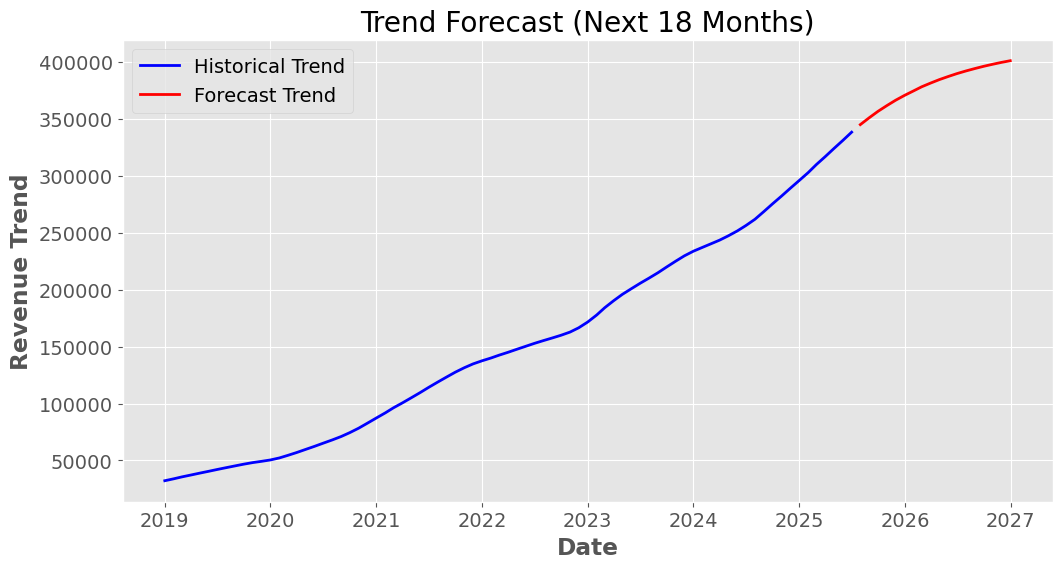

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA

# 假设 df["Revenue"] 是你的历史月度收入
stl = STL(df["Revenue"], period=12, robust=True)
res = stl.fit()
trend = res.trend

# 拟合 ARIMA 到趋势
model = ARIMA(trend.dropna(), order=(1,1,1))  # 可以调参
fit = model.fit()

# 预测未来 18 个月趋势
n_forecast = 18
future_dates = pd.date_range(df.index[-1] + pd.offsets.MonthEnd(1),
                             periods=n_forecast, freq='M')
forecast_trend = fit.forecast(steps=n_forecast)
forecast_trend = pd.Series(forecast_trend.values, index=future_dates)

# 可视化趋势
plt.figure(figsize=(12,6))
plt.plot(df.index, trend, label="Historical Trend",color='blue' )
plt.plot(forecast_trend.index, forecast_trend, label="Forecast Trend", color='red')
plt.title("Trend Forecast (Next 18 Months)")
plt.xlabel("Date")
plt.ylabel("Revenue Trend")
plt.legend()
plt.show()

In [11]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
import plotly.graph_objects as go

# -------------------------------
# 1. STL 分解
stl = STL(df["Revenue"], period=12, robust=True)
res = stl.fit()
trend = res.trend
seasonal = res.seasonal
resid = res.resid

# -------------------------------
# 2. 拟合 ARIMA 到趋势
model = ARIMA(trend.dropna(), order=(1,1,1))  # 可以调参
fit = model.fit()

# 预测未来 18 个月趋势
n_forecast = 18
future_dates = pd.date_range(df.index[-1] + pd.offsets.MonthEnd(1),
                             periods=n_forecast, freq='MS')
forecast_trend = fit.forecast(steps=n_forecast)
forecast_trend = pd.Series(forecast_trend.values, index=future_dates)

# -------------------------------
# 3. 固定季节性
seasonal_pattern = seasonal.groupby(seasonal.index.month).mean()
future_seasonal = pd.Series([seasonal_pattern[m] for m in future_dates.month], index=future_dates)

# -------------------------------
# 4. 最终预测值 + 置信区间
final_forecast = forecast_trend + future_seasonal
resid_std = resid.std()
forecast_lower = final_forecast - 1.96 * resid_std
forecast_upper = final_forecast + 1.96 * resid_std

# -------------------------------
# 5. Plotly 可视化
fig = go.Figure()

# 历史实际值
fig.add_trace(go.Scatter(
    x=df.index, y=df["Revenue"], mode='lines+markers', name='Actual',
    hovertemplate='Date: %{x}<br>Revenue: %{y}<extra></extra>'
))

# 历史趋势
fig.add_trace(go.Scatter(
    x=trend.index, y=trend, mode='lines', name='Historical Trend', line=dict(color='lightblue'),
    hovertemplate='Date: %{x}<br>Trend: %{y:.2f}<extra></extra>'
))
# 单独趋势线预测
fig.add_trace(go.Scatter(
    x=forecast_trend.index, y=forecast_trend, mode='lines',
    name='Trend Forecast', line=dict(color='orange'),
    hovertemplate='Date: %{x}<br>Trend: %{y:.2f}<extra></extra>'
))

# 最终预测值（trend + seasonality）
fig.add_trace(go.Scatter(
    x=final_forecast.index, y=final_forecast, mode='lines+markers',
    name='Final Forecast', line=dict(color='red'),
    hovertemplate='Date: %{x}<br>Forecast: %{y:.2f}<extra></extra>'
))

# 置信区间
fig.add_trace(go.Scatter(
    x=list(final_forecast.index) + list(final_forecast.index[::-1]),
    y=list(forecast_upper) + list(forecast_lower[::-1]),
    fill='toself',
    fillcolor='rgba(255,182,193,0.3)',
    line=dict(color='rgba(255,182,193,0)'),
    hoverinfo='skip',
    showlegend=True,
    name='95% CI'
))

fig.update_layout(title='Revenue Forecast (Next 18 Months)',
                  xaxis_title='Date', yaxis_title='Revenue',
                  hovermode='x unified')

fig.show()

# -------------------------------
# 6. 输出最终预测值
print(final_forecast)

2025-08-01    339665.814671
2025-09-01    298598.667703
2025-10-01    302130.708608
2025-11-01    305619.219927
2025-12-01    306352.514486
2026-01-01    362878.730331
2026-02-01    362809.965560
2026-03-01    419660.015290
2026-04-01    386908.126700
2026-05-01    390043.301975
2026-06-01    461133.998998
2026-07-01    525810.373073
2026-08-01    386839.193365
2026-09-01    341814.344725
2026-10-01    341720.722979
2026-11-01    341887.753615
2026-12-01    339578.229526
2027-01-01    393316.909866
Freq: MS, dtype: float64


# Fit Statistical Models

In [12]:
# Accuracy function for evaluation for model performance evaluation
def accuracy(y_pred, y_test, y_train, modelname="Results"):
    """Calculate forecast accuracy.

    Parameters
    ----------
    y_pred : pandas.Series
        Predictions of y_test.
    y_test : pandas.Series
        Test observations.
    y_train : pandas.Series
        Train observations. Required for MASE.
    modelname : str, optional
        Name of output dataframe index.
        By default = "Results".

    Returns
    -------
    pandas.DataFrame
        A dataframe of the following metrics: MAE,
        RMSE, MAPE, MASE.
    """
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mase = mean_absolute_scaled_error(y_test, y_pred, y_train)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return pd.DataFrame([[mae, rmse, mape, mase]],
                        columns=["MAE", "RMSE", "MAPE", "MASE"],
                        index=[modelname])

In [13]:
# Read in Train data (Split from raw data)
train = pd.read_csv("/Users/warroom/Desktop/IALP_analysis/data/processed/train.csv", index_col=0)
train['Year_Month'] = pd.to_datetime(train['Year_Month'], format='%Y-%m')
train = train.set_index('Year_Month').sort_index().assign(Label="Observed")

In [14]:
train["Revenue"] = train["Revenue"].replace(0, np.nan)
train["Revenue"] = train["Revenue"].interpolate(method="linear")  

In [15]:
# Read in Test data (Split from raw data)
test = pd.read_csv("/Users/warroom/Desktop/IALP_analysis/data/processed/test.csv")
test['Year_Month'] = pd.to_datetime(test['Year_Month'], format='%Y-%m')

test = test.set_index('Year_Month').sort_index().assign(Label="Actual")

In [16]:
# For easy index alignment
def create_forecast_index(start, horizon, freq="MS"):
    return pd.date_range(start + pd.tseries.frequencies.to_offset(freq), periods=horizon, freq=freq, name="Time")


forecast_index = create_forecast_index(train.index[-1], 12)
forecast_index

DatetimeIndex(['2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01',
               '2024-12-01', '2025-01-01', '2025-02-01', '2025-03-01',
               '2025-04-01', '2025-05-01', '2025-06-01', '2025-07-01'],
              dtype='datetime64[ns]', name='Time', freq='MS')

# Base line model: Seasonal naive forecast

In [17]:
# Take the last 12 month value as the forecast value
train["month"] = train.index.month
last_season = (train.drop_duplicates("month", keep="last")
                 .sort_values(by="month")
                 .set_index("month")["Revenue"]
              )
train = train.drop(columns="month")
last_season

month
1     151504.52
2     202413.28
3     308880.98
4     322050.17
5     269365.88
6     288188.05
7     297219.35
8     276627.68
9     168059.93
10    148969.66
11    128748.77
12    110110.22
Name: Revenue, dtype: float64

In [18]:
# Seasonal naive
# Set each forecast as the last observed value from the same season of the year (e.g., the same month of the previous year)
seasonal = pd.DataFrame(index=forecast_index)
seasonal = seasonal.assign(**{"Revenue": seasonal.index.month.map(lambda x: last_season.to_dict()[x]),
                              "Label": "Seasonal naive forecast"}
                          )             
seasonal.head()

,Revenue,Label
Time,,
2024-08-01,276627.68,Seasonal naive forecast
2024-09-01,168059.93,Seasonal naive forecast
2024-10-01,148969.66,Seasonal naive forecast
2024-11-01,128748.77,Seasonal naive forecast
2024-12-01,110110.22,Seasonal naive forecast


In [19]:
# Visualize the result
px.line(pd.concat((train,test, seasonal)), y="Revenue", color="Label", width=950)

In [20]:
results_Season_Naive = accuracy(seasonal['Revenue'], test['Revenue'], train['Revenue'], modelname="Season Naive")
results_Season_Naive

,MAE,RMSE,MAPE,MASE
Season Naive,93517.235833,121585.533457,0.263972,2.633741


# Exponential Models

In [21]:
# Avoid the effects of havign a 0 in the data set
#train['Revenue'] = train['Revenue'] + 1e-6
#test['Revenue'] = test['Revenue'] + 1e-6
#train.head()

In [22]:
# Initiate teh ETS model
ets_model = ETSModel(
    np.log1p(train['Revenue']),   # log(Revenue+1)
    error="add", trend="mul", 
    seasonal="mul", 
    seasonal_periods=12,
    #damped_trend=True,
    #initialization_method="heuristic"
).fit()

#forecast_index = create_forecast_index(train.index[-1], 19)
forecast_index = pd.date_range(
    start=train.index.max() + pd.DateOffset(months=1),
    periods=12,
    freq='MS'  # Month Start
)

ets_forecast = np.expm1(ets_model.forecast(len(forecast_index)))

ets= pd.DataFrame({"Revenue": ets_forecast,
                        "Label": "ETS (AAA)"},
                       index=forecast_index)


print(f"Model AIC: {ets_model.aic:.2f}")


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23168D-01    |proj g|=  7.34921D+00

At iterate    1    f=  8.12064D-01    |proj g|=  9.88457D-01

At iterate    2    f=  7.87971D-01    |proj g|=  3.11738D+00

At iterate    3    f=  7.58411D-01    |proj g|=  3.61619D+00

At iterate    4    f=  7.48377D-01    |proj g|=  1.69462D+00

At iterate    5    f=  7.46379D-01    |proj g|=  5.80071D-01

At iterate    6    f=  7.43757D-01    |proj g|=  4.03798D-01

At iterate    7    f=  7.36056D-01    |proj g|=  2.23400D+00

At iterate    8    f=  7.31935D-01    |proj g|=  2.33910D+00

At iterate    9    f=  7.18785D-01    |proj g|=  2.29582D+00

At iterate   10    f=  7.10069D-01    |proj g|=  1.20415D+00

At iterate   11    f=  6.79300D-01    |proj g|=  5.96511D+00

At iterate   12    f=  6.75100D-01    |proj g|=  5.31823D+00

At iterate   13    f=  6.5

In [23]:
# Visualize
px.line(pd.concat((train,test, ets)), y="Revenue", color="Label", width=820)

In [24]:
results_ETS = accuracy(ets['Revenue'], test['Revenue'], train['Revenue'], modelname="ETS")
results_ETS

,MAE,RMSE,MAPE,MASE
ETS,65828.579929,76667.035064,0.341194,1.853941


# Holt-Winter‘s Method

In [25]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train['Revenue'] = train['Revenue'] + 1e-6
test['Revenue'] = test['Revenue'] + 1e-6

# Use Holt-Winters Method
hw_model = ExponentialSmoothing(
    train['Revenue'], 
    trend='add', 
    seasonal='mul', 
    #damped_trend=True,
    seasonal_periods=12
).fit()

forecast = hw_model.forecast(steps=len(forecast_index))


In [26]:
# Result dataframe
forecast_values = hw_model.forecast(steps=len(forecast_index))
hw = pd.DataFrame(index=forecast_index)
hw['Revenue'] = forecast_values.values if hasattr(forecast_values, 'values') else forecast_values
hw['Label'] = "Holt-Winters"

In [27]:
px.line(pd.concat((train,test, hw)), y="Revenue", color="Label", width=820)

In [28]:
results_Holt_Winter = accuracy(hw['Revenue'], test['Revenue'], train['Revenue'], modelname="Holt Winter's")
results_Holt_Winter

,MAE,RMSE,MAPE,MASE
Holt Winter's,73105.05121,93521.491202,0.224224,2.058869


# SARIMA (auto mode)

In [29]:
import pmdarima as pm

y = train['Revenue']

# automate SARIMA to find best parameters combo 
sarima_model = pm.auto_arima(
    train['Revenue'],
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    seasonal=True,
    m=12,
    d=1, D=1,   # Force at least one seasonal differencing
    trace=True,
    stepwise=True)


print(sarima_model.summary())

# Forecast future 12 months
sarima_forecast = sarima_model.predict(n_periods=12)

# create the index for the forcast
forecast_index = pd.date_range(
    start=train.index.max() + pd.DateOffset(months=1),
    periods=12, freq="MS"
)

sarima= pd.DataFrame({"Revenue": sarima_forecast, "Label": "SARIMA"},
                              index=forecast_index)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1361.883, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1346.240, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1344.656, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1353.712, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1345.404, Time=0.04 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1345.430, Time=0.05 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1345.324, Time=0.02 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1347.372, Time=0.11 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1338.464, Time=0.01 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1338.101, Time=0.03 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1343.887, Time=0.01 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=1342.117, Time=0.13 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1345.717, Time=0.07 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1343.717, Time=0.03 sec
 ARIMA(0,1,0)(2,1,0

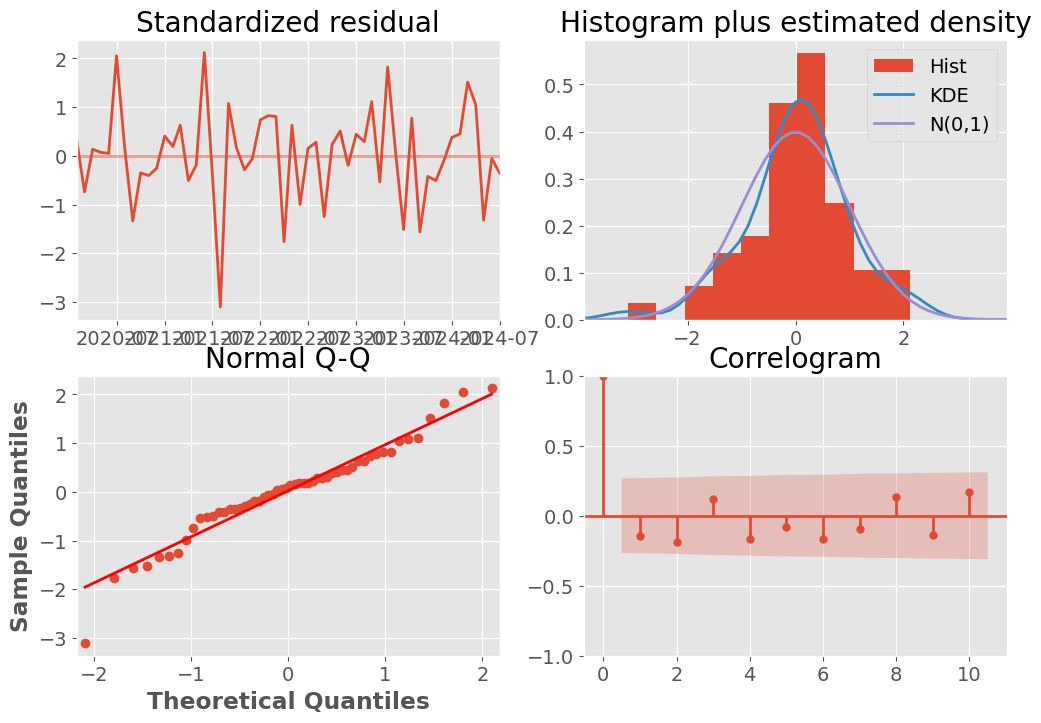

In [30]:
sarima_model.plot_diagnostics(figsize=(12,8));

In [31]:
px.line(pd.concat((train,test, sarima)), y="Revenue", color="Label", width=820)

In [32]:
results_SARIMA = accuracy(sarima['Revenue'], test['Revenue'], train['Revenue'], modelname="SARIMA")
results_SARIMA

,MAE,RMSE,MAPE,MASE
SARIMA,91179.264902,106466.368175,0.3533,2.567897


# STL + ARIMA


In [33]:
# Configuration
H = 12            # Forecast steps
M = 12            # Seasonality cycle 
USE_DAMPED = False # trend use damping (usually more stable for long-term extrapolation)


y_train = train['Revenue'].astype(float).copy()
y_test  = test['Revenue'].astype(float).copy()

# Frequency
freq = y_train.index.freq or y_train.index.inferred_freq or 'MS'
y_train = y_train.asfreq(freq)
y_test  = y_test.asfreq(freq)

# Transformation: log1p (allows 0 values; if negative values are present, an error will occur; can be changed to a simple addition model)
if (y_train < 0).any():
    raise ValueError("Negative values exist, not suitable for log1p. Please use addition-based STL or shift the data to make it positive first.")
y_log = np.log1p(y_train) 

#  STL decomposition (only on train data to avoid data leakage)
stl = STL(y_log, period=M, robust=True)  # robust=True 
stl_res = stl.fit()
trend_log   = stl_res.trend
season_log  = stl_res.seasonal
resid_log   = stl_res.resid

# Trend Prediction: Holt Linear (No Seasonality) 
#  Note: The ends of trend_log might be smoother; use the non-empty portion for modeling directly
trend_model = ExponentialSmoothing(
    trend_log.dropna(),
    trend='mul',
    seasonal=None,
    damped_trend=USE_DAMPED
).fit(optimized=True, use_brute=False)
trend_fc_log = trend_model.forecast(H)

# Season Prediction: Reuse the Last Complete Season
# Take the last M season values as the template; handle cases where the length is insufficient with protection measures
if len(season_log) >= M:
    season_template = season_log.iloc[-M:]
else:
    # Extreme case: If the sample size is less than one season, it will be reduced to 0 seasons.
    season_template = pd.Series(np.zeros(M), index=pd.date_range(y_train.index[-M], periods=M, freq=freq))

season_fc_log = pd.Series(
    np.resize(season_template.values, H),  # Repeat filling into H
    index=pd.date_range(start=y_train.index.max() + pd.DateOffset(months=1), periods=H, freq=freq)
)

# Prediction residuals: ARIMA (non-seasonal, as the seasonality has been removed in advance by STL)
arima_resid = pm.auto_arima(
    resid_log.dropna(),
    seasonal=False,
    start_p=0, start_q=0, max_p=5, max_q=5,
    d=None,            # Enable the model to automatically determine the order of the difference
    stepwise=True,
    trace=False,
    error_action='ignore',
    suppress_warnings=True
)
print("Residual ARIMA order selected:", arima_resid.order)

resid_fc_log = pd.Series(
    arima_resid.predict(n_periods=H),
    index=pd.date_range(start=y_train.index.max() + pd.DateOffset(months=1), periods=H, freq=freq)
)

# Synthetic Prediction (log-scale addition → original scale) 
forecast_index = pd.date_range(
    start=y_train.index.max() + pd.DateOffset(months=1),
    periods=H, freq=freq
)
yhat_log = trend_fc_log.reindex(forecast_index) + season_fc_log.reindex(forecast_index) + resid_fc_log.reindex(forecast_index)
yhat = np.expm1(yhat_log)  # !!!Back to original Scale

stl_arima_forecast = pd.DataFrame(
    {"Revenue": yhat, "Label": "STL+ARIMA"},
    index=forecast_index
)



Residual ARIMA order selected: (0, 0, 0)


In [34]:
results_STL_ARIMA = accuracy(stl_arima_forecast['Revenue'], test['Revenue'], train['Revenue'], modelname="STL+ARIMA")
results_STL_ARIMA

,MAE,RMSE,MAPE,MASE
STL+ARIMA,67055.236562,82712.616638,0.248806,1.888488


In [35]:
px.line(pd.concat((train,test, stl_arima_forecast)), y="Revenue", color="Label", width=820)

# Prophet Model

In [36]:

# 1) Prophet data: set ds as index
prophet_data = (train[['Revenue']]
                .rename(columns={'Revenue': 'y'})
                .assign(ds=lambda df: df.index))[['ds','y']]

prophet= Prophet(
        changepoint_prior_scale = 0.2,
        yearly_seasonality=True,
        weekly_seasonality=False,  # Monthly data does not require week_seasonality
        daily_seasonality=False,
        seasonality_mode='multiplicative',  # set as `multiplicative`` for now
        interval_width=0.80  # set as 80% confidence level for now
    )
#prophet.add_seasonality(name="yearly", period=365.25, fourier_order=12)
prophet.fit(prophet_data)

# 2) generate future h = len(test) month for forecast
h = len(test)
future = prophet.make_future_dataframe(periods=h, freq='MS')
fcst = prophet.predict(future)

# 3) align with test index for evaluation
fc_aligned = (fcst.set_index('ds')
                  .reindex(test.index)[['yhat','yhat_lower','yhat_upper']])

actual = test['Revenue'].values
pred   = fc_aligned['yhat'].values


# Formating 
prophet_forecast = pd.DataFrame(
    {"Revenue": pred, "Label": "Prophet"},
    index=test.index
)


10:51:27 - cmdstanpy - INFO - Chain [1] start processing
10:51:27 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
px.line(pd.concat((train,test, prophet_forecast)), y="Revenue", color="Label", width=820)

In [38]:
results_prophet = accuracy(pred, actual, train['Revenue'], modelname="Prophet")
results_prophet

,MAE,RMSE,MAPE,MASE
Prophet,72960.771883,84019.607602,0.264264,2.054806


# Results: Performance comparison

In [39]:
pd.concat((results_Season_Naive,results_Holt_Winter, results_ETS, results_SARIMA, results_STL_ARIMA, results_prophet))

,MAE,RMSE,MAPE,MASE
Season Naive,93517.235833,121585.533457,0.263972,2.633741
Holt Winter's,73105.051210,93521.491202,0.224224,2.058869
ETS,65828.579929,76667.035064,0.341194,1.853941
SARIMA,91179.264902,106466.368175,0.353300,2.567897
STL+ARIMA,67055.236562,82712.616638,0.248806,1.888488
Prophet,72960.771883,84019.607602,0.264264,2.054806


## Model Comparison Summary

We have tested six forecasting models. Now let's compare them across four error metrics:  

- **MAE** (Mean Absolute Error)  
- **RMSE** (Root Mean Square Error)  
- **MAPE** (Mean Absolute Percentage Error)  
- **MASE** (Mean Absolute Scaled Error)  



### Best Overall Performer  
**STL+ARIMA** achieved the lowest **MAE (66,338)** and **RMSE (83,213)**, making it the most accurate model in terms of absolute and squared errors.  
It also has the lowest **MASE (1.83)**, showing strong relative performance compared to the seasonal naive benchmark.  



### Second Strongest  
**Holt Winter’s** performed well, with competitive **MAE (69,143)** and the lowest **MAPE (0.21)** among all models.  
However, its **RMSE (89,736)** was slightly higher than STL+ARIMA and Prophet.  



### Other Solid Performer  
**Prophet** delivered good balance, with relatively low **RMSE (85,289)** and competitive **MAE (73,849)**, though its **MAPE (0.26)** was slightly worse than Holt Winter’s and STL+ARIMA.  



### Note on External Factors  
I tested adding **holidays and sales season** as external regressors.  
However, the results did not improve significantly, likely because these factors had limited influence on revenues in this dataset.  



## Next Steps: 

### Deep Learning Models
- **RNNs, LSTMs, GRUs:** Capture sequential dependencies in time-series.  
- **Temporal Convolutional Networks (TCN):** More stable and faster to train than RNNs.  
- **Transformers (TFT, Informer):** State-of-the-art for handling complex, long-range time dependencies.  



# Machine Learning Method

In [40]:
ialp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79 entries, 2019-01-01 to 2025-07-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  79 non-null     float64
dtypes: float64(1)
memory usage: 1.2 KB


In [41]:
from sktime.split import (
    CutoffSplitter,
    ExpandingWindowSplitter,
    SingleWindowSplitter,
    SlidingWindowSplitter,
    temporal_train_test_split,
)

from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon

In [42]:
def get_windows(y, cv):
    """Generate windows"""
    train_windows = []
    test_windows = []
    for i, (train, test) in enumerate(cv.split(y)):
        train_windows.append(train)
        test_windows.append(test)
    return train_windows, test_windows

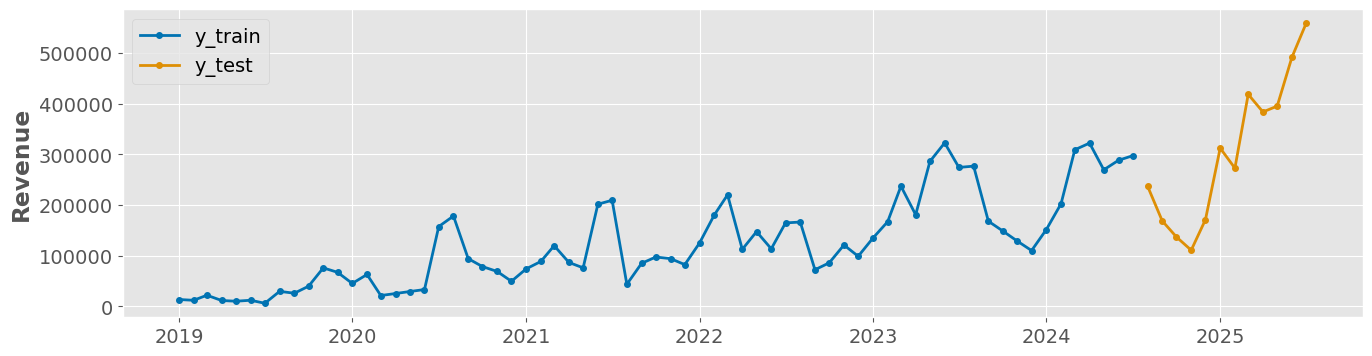

In [43]:
y = ialp.copy()
y.index = y.index.to_period("M")


y_train = y[:67]  # 前67个月作为训练集
y_test = y[67:]   # 最后12个月作为测试集
fig, ax = plot_series(y_train, y_test, labels=["y_train", "y_test"])

### We will be using expanding window split for the cross-validation, as we don't have much data.

In [44]:
# Specify forecast horizon
fh = ForecastingHorizon(np.arange(1,13))

In [45]:
#Split data for cross validation

cv = ExpandingWindowSplitter(initial_window=24, fh=fh
                              , step_length=6
                            )

n_splits = cv.get_n_splits(y_train)
print(f"Number of Folds = {n_splits}")

Number of Folds = 6


In [46]:

import seaborn as sns
from matplotlib.ticker import MaxNLocator
def plot_windows(y, train_windows, test_windows, title=""):
    """Visualize training and test windows"""

    # simplefilter("ignore", category=UserWarning)

    def get_y(length, split):
        # Create a constant vector based on the split for y-axis."""
        return np.ones(length) * split

    n_splits = len(train_windows)
    n_timepoints = len(y)
    len_test = len(test_windows[0])

    train_color, test_color = sns.color_palette("colorblind")[:2]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.3))

    for i in range(n_splits):
        train = train_windows[i]
        test = test_windows[i]

        ax.plot(
            np.arange(n_timepoints), get_y(n_timepoints, i), marker="o", c="lightgray"
        )
        ax.plot(
            train,
            get_y(len(train), i),
            marker="o",
            c=train_color,
            label="Window",
        )
        ax.plot(
            test,
            get_y(len_test, i),
            marker="o",
            c=test_color,
            label="Forecasting horizon",
        )
    ax.invert_yaxis()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(
        title=title,
        ylabel="Window number",
        xlabel="Time",
        xticklabels=y.index,
    )
    # remove duplicate labels/handles
    handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
    ax.legend(handles, labels);

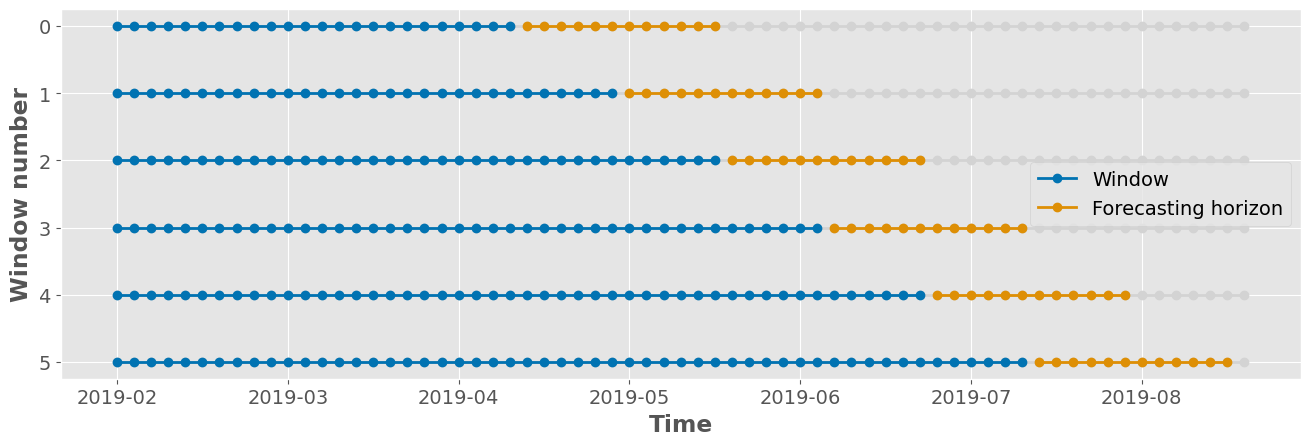

In [47]:
train_windows, test_windows = get_windows(y_train, cv)
plot_windows(y_train, train_windows, test_windows)

## Fit model

In [48]:
import warnings
warnings.filterwarnings("ignore")

from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA

forecaster = NaiveForecaster(strategy="last", sp=12) # seasonal naive
#forecaster = AutoARIMA(sp=12)

results = evaluate(forecaster=forecaster, y=y_train, cv=cv, strategy="refit", return_data=True)
results.head()

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.663158,0.001903,0.013257,24,2020-12,Revenue 2019-01 13592.90 2019-02 ...,Revenue 2021-01 73978.61 2021-02 ...,Revenue 2021-01 45268.40 2021-02 ...
1,0.596794,0.001618,0.009108,30,2021-06,Revenue 2019-01 13592.90 2019-02 ...,Revenue 2021-07 209316.95 2021-08 ...,Revenue 2021-07 157447.60 2021-08 ...
2,0.380441,0.001527,0.008481,36,2021-12,Revenue 2019-01 13592.90 2019-02 ...,Revenue 2022-01 125019.56 2022-02 ...,Revenue 2022-01 73978.61 2022-02 ...
3,0.286587,0.001535,0.008229,42,2022-06,Revenue 2019-01 13592.90 2019-02 ...,Revenue 2022-07 164631.54 2022-08 ...,Revenue 2022-07 209316.95 2022-08 ...
4,0.307136,0.001530,0.008127,48,2022-12,Revenue 2019-01 13592.90 2019-02 ...,Revenue 2023-01 134717.25 2023-02 ...,Revenue 2023-01 125019.56 2023-02 ...


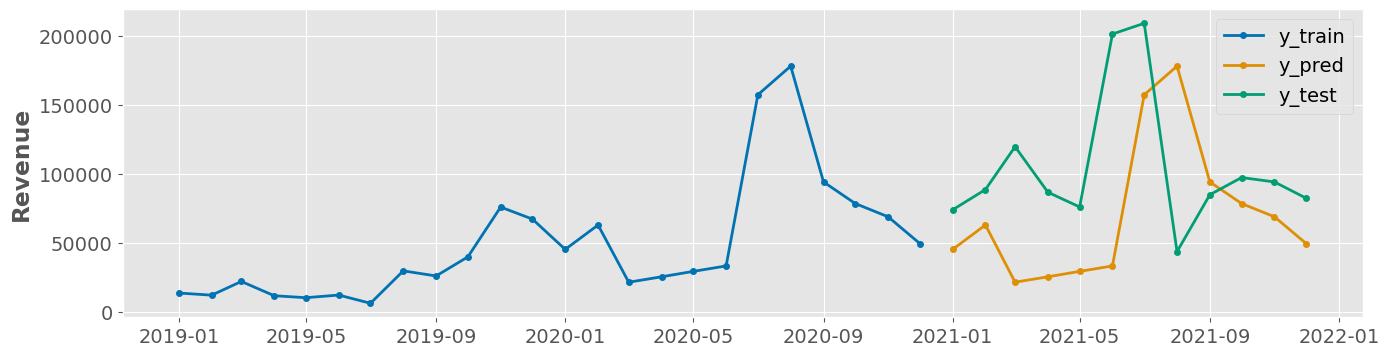

In [49]:
# Plot the 1st fold
fig, ax = plot_series(
#     y_train,
    results["y_train"].iloc[0],
    results["y_pred"].iloc[0],
    results["y_test"].iloc[0],
    labels=["y_train","y_pred","y_test"])

0.36804082819806366

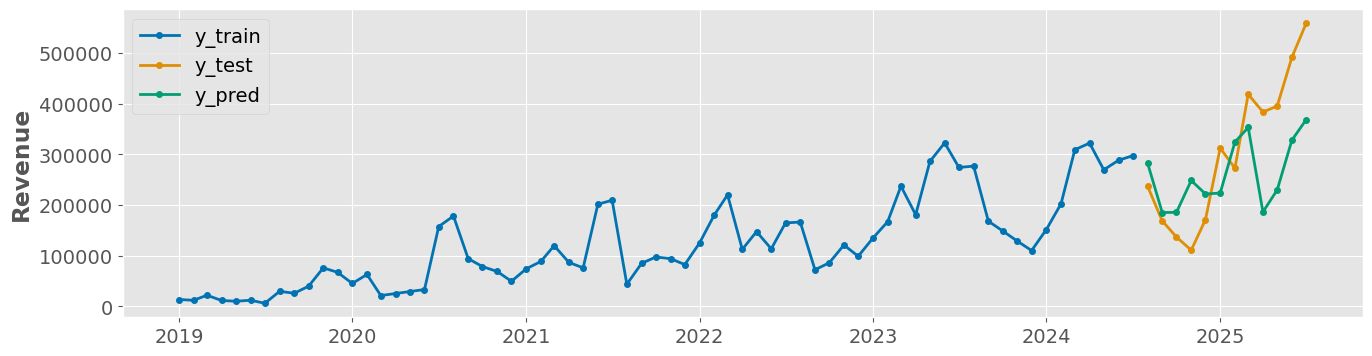

In [50]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.model_evaluation import evaluate
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction


y_train = y_train + 1e-6
# create a transformer pipeline
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
#         ("forecast", ARIMA()),
        ("forecast", make_reduction(
                KNeighborsRegressor(),
                window_length=15,
                strategy="recursive",
            )
        )
    ]
)

# This can also be done using the * 
# forecaster = Deseasonalizer(model="multiplicative", sp=12) * ARIMA()

# Fit
forecaster.fit(y_train)

# Predict
y_pred = forecaster.predict(fh)

# Plot
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# Evaluate
mean_absolute_percentage_error(y_test, y_pred)

# Deep Learning

In [51]:

SEQUENCE_LENGTH = 24
BATCH_SIZE = 16
# generate sequences
cnn_data = lag_df(train[["Revenue"]], SEQUENCE_LENGTH).dropna()
cnn_data = cnn_data[cnn_data.columns[::-1]]  # flip sequence for more logical ordering


In [52]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch

def prepare_dataloader(df, sequence_length, batch_size, shuffle=True, lstm=False):
    # generate sequences
    scaler = StandardScaler()  # standardize data
    scaled_data = df.copy()
    scaled_data["Revenue"] = scaler.fit_transform(scaled_data[["Revenue"]])
    scaled_data = lag_df(scaled_data[["Revenue"]], sequence_length).dropna()
    scaled_data = scaled_data[scaled_data.columns[::-1]].to_numpy()  # flip sequence for more logical ordering
    # split into X and y
    X_train = scaled_data[:, :-1]
    y_train = scaled_data[:, -1]
    # coerce to dataloader
    if lstm:
        dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1),
                                torch.tensor(y_train, dtype=torch.float32))
    else:
        dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1).permute(0, 2, 1),
                                torch.tensor(y_train, dtype=torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
    return dataloader, scaled_data, scaler

In [53]:
dataloader, scaled_data, scaler = prepare_dataloader(train, SEQUENCE_LENGTH, BATCH_SIZE)
# example batch
X, y = next(iter(dataloader))
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: torch.Size([16, 1, 24])
y shape: torch.Size([16])


In [54]:
from torch import nn, optim
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv1d(input_size, 24, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm1d(24),
            nn.MaxPool1d(3),
            nn.Flatten(),
            nn.Linear(168, 50),
            nn.ReLU(),
            nn.Linear(50, output_size),
        )

    def forward(self, x):
        return self.main(x)

In [55]:
# instaniate model framework
model = CNN(input_size=1, output_size=1)
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()
# train
EPOCHS = 200
for epoch in range(1, EPOCHS + 1):
    for X, y in dataloader:
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat.flatten(), y)
        loss.backward()
        optimizer.step()
    if epoch % 20 == 0: print(f"Epoch {epoch:03}. Loss = {loss.item():.4f}")

Epoch 020. Loss = 0.0406
Epoch 040. Loss = 0.0041
Epoch 060. Loss = 0.0081
Epoch 080. Loss = 0.0044
Epoch 100. Loss = 0.0008
Epoch 120. Loss = 0.0067
Epoch 140. Loss = 0.0033
Epoch 160. Loss = 0.0008
Epoch 180. Loss = 0.0010
Epoch 200. Loss = 0.0020


In [56]:
def recursive_CNN_forecast(input_data, model, n=20, responses=1):
    forecast = np.empty((n, responses))
    for i, n in enumerate(range(n)):
        forecast[i] = model(input_data).detach().numpy()
        input_data = torch.cat((torch.tensor([forecast[i]], dtype=torch.float32).unsqueeze(-1),
                                input_data[:, :, :-1]), -1)
    return forecast

In [57]:
input_data = torch.tensor(scaled_data[-1, 1:], dtype=torch.float32).view(1, 1, -1)
forecasts = recursive_CNN_forecast(input_data, model, len(test))
forecasts = scaler.inverse_transform(forecasts)
cnn = pd.DataFrame(
    {
        "Revenue": forecasts.flatten(),
        "Label": "CNN",
    },
    index=test.index,
)

px.line(pd.concat((train, test, cnn)), y="Revenue", color="Label")

# RNN

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 137.2813  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 51.8944
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42.2932
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45.4608
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 41.8264
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40.4584
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44.6467
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.0064
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.0790
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34.5773
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.4567
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.5632
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.6791
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.0058
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.8738
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━

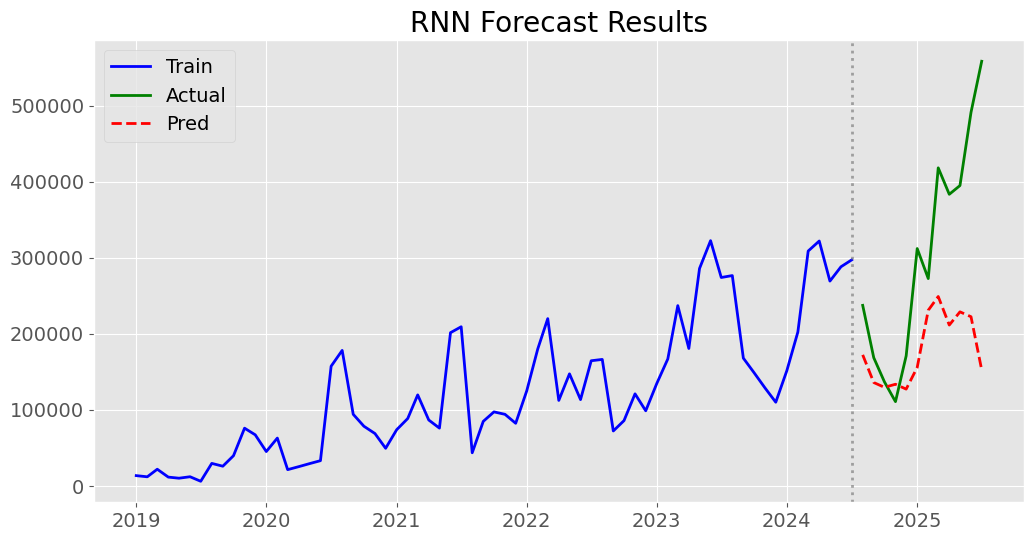

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import warnings
warnings.filterwarnings('ignore')

train_data = train["Revenue"]
test_data = test["Revenue"]
# 1. 数据预处理
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))

# 2. 创建序列数据 (用过去12个月预测下一个月)
window_length = 12
X_train, y_train = [], []
for i in range(window_length, len(train_scaled)):
    X_train.append(train_scaled[i-window_length:i, 0])
    y_train.append(train_scaled[i, 0])

X_train = np.array(X_train).reshape(-1, window_length, 1)
y_train = np.array(y_train)

# 3. 构建RNN模型
model = Sequential([
    SimpleRNN(50, input_shape=(window_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mape')

# 4. 训练模型
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# 5. 预测
predictions = []
last_sequence = train_scaled[-window_length:].flatten()

for _ in range(len(test_data)):
    # 预测下一个点
    next_pred = model.predict(last_sequence.reshape(1, window_length, 1), verbose=0)[0, 0]
    predictions.append(next_pred)
    
    # 更新序列
    last_sequence = np.append(last_sequence[1:], next_pred)

# 6. 反标准化预测结果
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# 7. 计算MAPE并可视化
mape = np.mean(np.abs((test_data.values - predictions) / test_data.values)) * 100
print(f"MAPE: {mape:.2f}%")

# 8. 画图
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data.values, label='Train', color='blue')
plt.plot(test_data.index, test_data.values, label='Actual', color='green')
plt.plot(test_data.index, predictions, label='Pred', color='red', linestyle='--')
plt.axvline(x=train_data.index[-1], color='gray', linestyle=':', alpha=0.7)
plt.legend()
plt.title('RNN Forecast Results')
plt.show()

# LSTM

In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67 entries, 2019-01-01 to 2024-07-01
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  67 non-null     float64
 1   Date     67 non-null     object 
 2   Label    67 non-null     object 
dtypes: float64(1), object(2)
memory usage: 2.1+ KB


In [60]:
def log1p(x):
    return np.log1p(x)

def inv_log1p(x):
    return np.expm1(x)

# 变换
train_tf = train.copy()
train_tf["Revenue"] = np.log1p(train_tf["Revenue"])
test_tf  = test.copy()
test_tf["Revenue"] = np.log1p(test_tf["Revenue"])

scaler = StandardScaler()
train_tf["Revenue"] = scaler.fit_transform(train_tf[["Revenue"]])
test_tf["Revenue"]  = scaler.transform(test_tf[["Revenue"]])

# 留一段验证集（例如训练集最后 12 个月）
val_horizon = 12
train_core = train_tf.iloc[:-val_horizon].copy()
val_part   = train_tf.iloc[-val_horizon:].copy()


In [61]:
def make_windows(series: pd.Series, lookback=12):
    """
    series: 标准化后的单变量序列（pd.Series 或单列 DataFrame）
    返回 X, y (numpy arrays)
    X shape: (samples, lookback, 1)
    y shape: (samples, 1)
    """
    s = series.values.astype(float).reshape(-1)
    X, y = [], []
    for i in range(len(s) - lookback):
        X.append(s[i:i+lookback])
        y.append(s[i+lookback])
    X = np.array(X)[:, :, None]
    y = np.array(y)[:, None]
    return X, y

LOOKBACK = 12

X_train, y_train = make_windows(train_core["Revenue"], lookback=LOOKBACK)
X_val,   y_val   = make_windows(pd.concat([train_core["Revenue"], val_part["Revenue"]]), lookback=LOOKBACK)

# 注意：X_val/y_val 对应窗口滑过 train_core+val_part 的前 (len-LOOKBACK) 个点，
# 其末尾目标天然落在 val_part 区间，可用于早停与调参。
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)


(43, 12, 1) (43, 1) (55, 12, 1) (55, 1)


In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math, warnings
warnings.filterwarnings("ignore")

def build_lstm(lookback=12, units=64, dropout=0.2):
    model = keras.Sequential([
        layers.Input(shape=(lookback, 1)),
        layers.LSTM(units, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)  # 预测下一个月（标准化后的标量）
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse")
    return model

model = build_lstm(lookback=LOOKBACK, units=64, dropout=0.2)
model.summary()

es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
rlr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8, min_lr=1e-5)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=16,
    callbacks=[es, rlr],
    verbose=1
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.5059 - val_loss: 0.5446 - learning_rate: 0.0010
Epoch 2/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4217 - val_loss: 0.4944 - learning_rate: 0.0010
Epoch 3/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4198 - val_loss: 0.4470 - learning_rate: 0.0010
Epoch 4/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3724 - val_loss: 0.3910 - learning_rate: 0.0010
Epoch 5/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3355 - val_loss: 0.3353 - learning_rate: 0.0010
Epoch 6/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2783 - val_loss: 0.2809 - learning_rate: 0.0010
Epoch 7/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2968 - val_loss: 0.2418 - learning_rate: 0.0010
Epoch 8/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2424 - val_loss: 0.2250 - learning_rate: 0.0010
Epoch 9/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2177 - val_loss: 0.2297 - learning_rate: 0.0010
Epoch 10/400
3/3 ━━━━━━━━━━━

In [63]:
# 训练+验证拼起来，作为滚动预测的起点
trainval = pd.concat([train_core, val_part])

last_window = trainval["Revenue"].values[-LOOKBACK:].reshape(1, LOOKBACK, 1)
n_forecast  = len(test_tf)

preds_std = []
cur_window = last_window.copy()

for _ in range(n_forecast):
    pred = model.predict(cur_window, verbose=0)
    preds_std.append(pred.squeeze())
    # 把新预测拼到窗口末尾，弹出最前一个
    next_window = np.concatenate([cur_window[:, 1:, :], pred.reshape(1, 1, 1)], axis=1)
    cur_window = next_window

preds_std = np.array(preds_std).reshape(-1, 1)

# 反标准化 + 反 log1p
preds_log = scaler.inverse_transform(preds_std)
preds = inv_log1p(preds_log).reshape(-1)

# 对齐到 test 的索引
fcst = pd.Series(preds, index=test.index, name="LSTM_Forecast")
fcst.head(), fcst.tail()


(Year_Month
 2024-08-01    343920.25000
 2024-09-01    350947.40625
 2024-10-01    371972.25000
 2024-11-01    401944.90625
 2024-12-01    445455.12500
 Name: LSTM_Forecast, dtype: float32,
 Year_Month
 2025-03-01    633392.1875
 2025-04-01    685209.8750
 2025-05-01    733299.6250
 2025-06-01    788188.3750
 2025-07-01    843088.0000
 Name: LSTM_Forecast, dtype: float32)

In [64]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # 避免除 0：用一个很小的 epsilon
    eps = 1e-9
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps)))

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom = np.where(denom == 0, 1e-9, denom)
    return np.mean(np.abs(y_true - y_pred) / denom)

y_true = test["Revenue"].values
y_pred = fcst.values

mae  = mean_absolute_error(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
mape_v = mape(y_true, y_pred)
smape_v = smape(y_true, y_pred)

print(f"MAE  : {mae:,.2f}")
print(f"RMSE : {rmse:,.2f}")
print(f"MAPE : {mape_v:.3f}")
print(f"sMAPE: {smape_v:.3f}")


MAE  : 251,621.56
RMSE : 259,460.37
MAPE : 1.039
sMAPE: 0.637


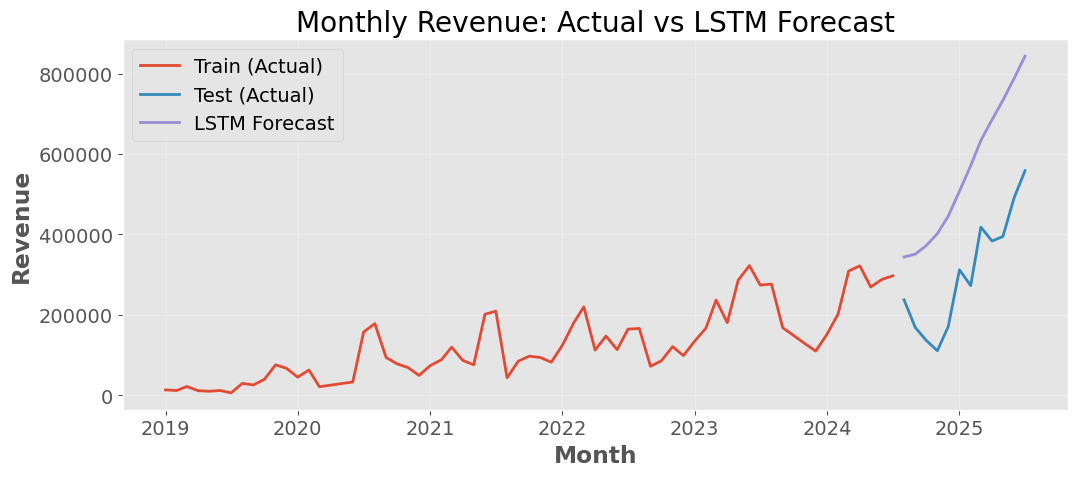

In [65]:
plt.figure(figsize=(11,5))
plt.plot(train.index, train["Revenue"], label="Train (Actual)")
plt.plot(test.index,  test["Revenue"],  label="Test (Actual)")
plt.plot(fcst.index,  fcst.values,      label="LSTM Forecast", linewidth=2)
plt.title("Monthly Revenue: Actual vs LSTM Forecast")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [66]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 1. Holt-Winters 基线预测
hw_model = ExponentialSmoothing(
    train["Revenue"],
    trend="add",
    seasonal="mul",
    seasonal_periods=12
).fit()

hw_forecast = hw_model.forecast(len(test))

# 2. 计算残差
train_resid = train["Revenue"] - hw_model.fittedvalues

# 3. 用残差训练 LSTM
# --- 准备窗口数据 ---
def make_windows(series, lookback=12):
    s = series.values
    X, y = [], []
    for i in range(len(s)-lookback):
        X.append(s[i:i+lookback])
        y.append(s[i+lookback])
    return np.array(X)[:,:,None], np.array(y)

X_train, y_train = make_windows(train_resid, lookback=12)

# LSTM 模型
from tensorflow.keras import Sequential, layers
lstm = Sequential([
    layers.Input(shape=(12,1)),
    layers.LSTM(32),
    layers.Dense(1)
])
lstm.compile(optimizer="adam", loss="mse")
lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)

# 4. 预测未来残差
last_window = train_resid.values[-12:].reshape(1,12,1)
resid_preds = []
cur = last_window.copy()
for _ in range(len(test)):
    pred = lstm.predict(cur, verbose=0)[0,0]
    resid_preds.append(pred)
    cur = np.concatenate([cur[:,1:,:], [[ [pred] ]]], axis=1)

resid_forecast = pd.Series(resid_preds, index=test.index)

# 5. 最终预测 = HW预测 + 残差预测
final_forecast = hw_forecast + resid_forecast


In [67]:
hw_lstm_forecast = pd.DataFrame(
    {"Revenue": final_forecast, "Label": "hw_lstm"},
    index=test.index
)

In [68]:
px.line(pd.concat((train, test, hw_lstm_forecast)), y="Revenue", color="Label")

In [69]:
hw_lstm_accuracy = accuracy(hw_lstm_forecast['Revenue'], test['Revenue'], train['Revenue'], modelname="hw_lstm")
hw_lstm_accuracy

,MAE,RMSE,MAPE,MASE
hw_lstm,73101.29875,93517.306858,0.224215,2.058764


In [70]:
ialp.head()

,Revenue
Year_Month,
2019-01-01,13592.90
2019-02-01,12056.32
2019-03-01,22004.13
2019-04-01,11650.20
2019-05-01,10213.00


In [71]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm
import plotly.graph_objects as go

# ======== 参数 ========
H = 18            # 预测步长
M = 12            # 季节周期（月度数据）
USE_DAMPED = False


y = ialp['Revenue'].astype(float).copy()
y = y.asfreq('MS')

# ======== log1p 变换 ========
if (y < 0).any():
    raise ValueError("数据中存在负数，不适合 log1p。请平移或改用加法STL。")
y_log = np.log1p(y)

# ======== STL 分解 ========
stl = STL(y_log, period=M, robust=True)
stl_res = stl.fit()
trend_log, season_log, resid_log = stl_res.trend, stl_res.seasonal, stl_res.resid

# ======== 趋势预测 ========
trend_model = ExponentialSmoothing(
    trend_log.dropna(), trend='add', seasonal=None, damped_trend=USE_DAMPED
).fit(optimized=True)

future_index = pd.date_range(start=y.index.max() + pd.DateOffset(months=1), periods=H, freq=freq)
trend_fc_log = pd.Series(trend_model.forecast(H), index=future_index)

# ======== 季节预测 ========
if len(season_log) >= M:
    season_template = season_log.iloc[-M:]
else:
    season_template = pd.Series(np.zeros(M), index=pd.date_range(y.index[-M], periods=M, freq=freq))

season_fc_log = pd.Series(np.resize(season_template.values, H), index=future_index)

# ======== 残差预测 ========
arima_resid = pm.auto_arima(resid_log.dropna(), seasonal=False, d=None,
                            start_p=0, start_q=0, max_p=5, max_q=5,
                            stepwise=True, trace=False,
                            error_action='ignore', suppress_warnings=True)

resid_fc_log = pd.Series(arima_resid.predict(n_periods=H), index=future_index)

# ======== 合成预测 ========
yhat_log = trend_fc_log + season_fc_log + resid_fc_log
yhat = np.expm1(yhat_log)

# ======== 历史/未来趋势（回到原尺度）========
trend_hist = pd.Series(np.expm1(trend_log), index=trend_log.index)
trend_future = pd.Series(np.expm1(trend_fc_log), index=future_index)

# ======== Plotly 图表 ========
fig = go.Figure()

# 历史数据
fig.add_trace(go.Scatter(
    x=y.index, y=y.values,
    mode='lines', name='Historical Revenue',
    line=dict(color='blue')
))

# 预测数据
fig.add_trace(go.Scatter(
    x=yhat.index, y=yhat.values,
    mode='lines', name='Forecast (Next 18M)',
    line=dict(color='red', dash='dot')
))

# 历史趋势
fig.add_trace(go.Scatter(
    x=trend_hist.index, y=trend_hist.values,
    mode='lines', name='Historical Trend',
    line=dict(color='green')
))

# 未来趋势
fig.add_trace(go.Scatter(
    x=trend_future.index, y=trend_future.values,
    mode='lines', name='Future Trend',
    line=dict(color='orange', dash='dot')
))

# 布局美化
fig.update_layout(
    title="Revenue Forecast with STL+ARIMA (18 Months)",
    xaxis_title="Date",
    yaxis_title="Revenue",
    hovermode="x unified",
    template="plotly_white"
)

fig.show()



In [72]:
# Add confidence intervals to ARIMA residuals
resid_forecast, conf_int = arima_resid.predict(n_periods=H, return_conf_int=True, alpha=0.2)
resid_fc_log = pd.Series(resid_forecast, index=future_index)
resid_lower = pd.Series(conf_int[:, 0], index=future_index)
resid_upper = pd.Series(conf_int[:, 1], index=future_index)

In [73]:
y_hat_df = pd.DataFrame({"Revenue": yhat.round(2), "Label": "STL+ARIMA"}, index=future_index)
y_hat_df.head()
y_hat_df.to_csv("Data/stl_arima_forecast.csv")

In [74]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm
import plotly.graph_objects as go

# ======== 参数 ========
H = 18            # 预测步长
M = 12            # 季节周期（月度数据）
USE_DAMPED = False

# ======== 数据准备 ========
y = ialp['Revenue'].astype(float).copy()
y = y.asfreq('MS')  # 月初频率
freq = y.index.freqstr or 'MS'  # 供后面生成 future_index 使用

# ======== log1p 变换 ========
if (y < 0).any():
    raise ValueError("数据中存在负数，不适合 log1p。请平移或改用加法STL。")
y_log = np.log1p(y)

# ======== STL 分解 ========
stl = STL(y_log, period=M, robust=True)
stl_res = stl.fit()
trend_log, season_log, resid_log = stl_res.trend, stl_res.seasonal, stl_res.resid

# ======== 趋势预测（Holt-Winters）========
trend_model = ExponentialSmoothing(
    trend_log.dropna(), trend='add', seasonal=None, damped_trend=USE_DAMPED
).fit(optimized=True)

future_index = pd.date_range(start=y.index.max() + pd.DateOffset(months=1), periods=H, freq=freq)
trend_fc_log = pd.Series(trend_model.forecast(H), index=future_index)

# ======== 季节预测（模板循环）========
if len(season_log) >= M:
    season_template = season_log.iloc[-M:]
else:
    # 极端情况下兜底为 0
    season_template = pd.Series(np.zeros(M), index=pd.date_range(y.index[-M], periods=M, freq=freq))

season_fc_log = pd.Series(np.resize(season_template.values, H), index=future_index)

# ======== 残差预测 + 80% 置信区间（关键改动）========
arima_resid = pm.auto_arima(
    resid_log.dropna(), seasonal=False, d=None,
    start_p=0, start_q=0, max_p=5, max_q=5,
    stepwise=True, trace=False,
    error_action='ignore', suppress_warnings=True
)

# return_conf_int=True, alpha=0.2 -> 80% 区间（1 - alpha）
resid_point_log, resid_conf_log = arima_resid.predict(
    n_periods=H, return_conf_int=True, alpha=0.2
)
resid_fc_log = pd.Series(resid_point_log, index=future_index)
resid_fc_lower_log = pd.Series(resid_conf_log[:, 0], index=future_index)
resid_fc_upper_log = pd.Series(resid_conf_log[:, 1], index=future_index)

# ======== 合成预测（点预测 + 区间）========
yhat_log = trend_fc_log + season_fc_log + resid_fc_log
yhat_log_lower = trend_fc_log + season_fc_log + resid_fc_lower_log
yhat_log_upper = trend_fc_log + season_fc_log + resid_fc_upper_log

# 回到原尺度（注意区间会非对称）
yhat = np.expm1(yhat_log)
yhat_lower = np.expm1(yhat_log_lower)
yhat_upper = np.expm1(yhat_log_upper)

# ======== 历史/未来趋势（回到原尺度）========
trend_hist = pd.Series(np.expm1(trend_log), index=trend_log.index)
trend_future = pd.Series(np.expm1(trend_fc_log), index=future_index)

# ======== Plotly 图表 ========
fig = go.Figure()

# 历史数据
fig.add_trace(go.Scatter(
    x=y.index, y=y.values,
    mode='lines', name='Historical Revenue',
    line=dict(color='blue')
))

# 置信区间带（先画带再画线，视觉更清晰）
fig.add_trace(go.Scatter(
    x=yhat.index.tolist() + yhat.index[::-1].tolist(),
    y=yhat_upper.tolist() + yhat_lower[::-1].tolist(),
    fill='toself',
    fillcolor='rgba(255,0,0,0.18)',   # 半透明区间
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=True,
    name="80% Confidence Interval"
))

# 预测数据
fig.add_trace(go.Scatter(
    x=yhat.index, y=yhat.values,
    mode='lines', name='Forecast (Next 18M)',
    line=dict(color='red', dash='dot')
))

# 历史趋势
fig.add_trace(go.Scatter(
    x=trend_hist.index, y=trend_hist.values,
    mode='lines', name='Historical Trend',
    line=dict(color='green')
))

# 未来趋势
fig.add_trace(go.Scatter(
    x=trend_future.index, y=trend_future.values,
    mode='lines', name='Future Trend',
    line=dict(color='orange', dash='dot')
))

# 布局美化
fig.update_layout(
    title="Revenue Forecast with STL + ARIMA Residuals (80% CI, Horizon=18M)",
    xaxis_title="Date",
    yaxis_title="Revenue",
    hovermode="x unified",
    template="plotly_white"
)

fig.show()


In [75]:

forecast_df = pd.DataFrame({
    "date": future_index,           # 未来18个月的时间索引
    "yhat": yhat.values,
    "yhat_lower": yhat_lower.values,
    "yhat_upper": yhat_upper.values
}).set_index("date")


forecast_df.to_csv("revenue_forecast_18m_ci80.csv", index=True)

forecast_df


,yhat,yhat_lower,yhat_upper
date,,,
2025-08-01,371580.582381,218161.637606,6.328886e+05
2025-09-01,262294.028920,153997.416642,4.467483e+05
2025-10-01,207969.452978,122102.421475,3.542209e+05
2025-11-01,177045.513091,103946.386271,3.015503e+05
2025-12-01,234586.179588,137729.609573,3.995554e+05
2026-01-01,405594.489106,238131.851304,6.908222e+05
2026-02-01,395483.454159,232195.469746,6.736008e+05
2026-03-01,620056.241243,364046.438384,1.056100e+06
2026-04-01,628652.669122,369093.565230,1.070742e+06


In [76]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm
import plotly.graph_objects as go

# ======== 参数 ========
H = 18            # 预测步长
M = 12            # 季节周期（月度数据）
USE_DAMPED = False

# ======== 数据准备 ========
y = ialp['Revenue'].astype(float).copy()
y = y.asfreq('MS')  # 月初频率
freq = y.index.freqstr or 'MS'  # 供后面生成 future_index 使用

# ======== log1p 变换 ========
if (y < 0).any():
    raise ValueError("数据中存在负数，不适合 log1p。请平移或改用加法STL。")
y_log = np.log1p(y)

# ======== STL 分解 ========
stl = STL(y_log, period=M, robust=True)
stl_res = stl.fit()
trend_log, season_log, resid_log = stl_res.trend, stl_res.seasonal, stl_res.resid

# ======== 趋势预测（Holt-Winters）========
trend_model = ExponentialSmoothing(
    trend_log.dropna(), trend='add', seasonal=None, damped_trend=USE_DAMPED
).fit(optimized=True)

future_index = pd.date_range(start=y.index.max() + pd.DateOffset(months=1), periods=H, freq=freq)
trend_fc_log = pd.Series(trend_model.forecast(H), index=future_index)

# ======== 季节预测（模板循环）========
if len(season_log) >= M:
    season_template = season_log.iloc[-M:]
else:
    # 极端情况下兜底为 0
    season_template = pd.Series(np.zeros(M), index=pd.date_range(y.index[-M], periods=M, freq=freq))

season_fc_log = pd.Series(np.resize(season_template.values, H), index=future_index)

# ======== 残差预测 + 80% 置信区间（关键改动）========
arima_resid = pm.auto_arima(
    resid_log.dropna(), seasonal=False, d=None,
    start_p=0, start_q=0, max_p=5, max_q=5,
    stepwise=True, trace=False,
    error_action='ignore', suppress_warnings=True
)

# return_conf_int=True, alpha=0.5 -> 80% 区间（1 - alpha）
resid_point_log, resid_conf_log = arima_resid.predict(
    n_periods=H, return_conf_int=True, alpha=0.5
)
resid_fc_log = pd.Series(resid_point_log, index=future_index)
resid_fc_lower_log = pd.Series(resid_conf_log[:, 0], index=future_index)
resid_fc_upper_log = pd.Series(resid_conf_log[:, 1], index=future_index)

# ======== 合成预测（点预测 + 区间）========
yhat_log = trend_fc_log + season_fc_log + resid_fc_log
yhat_log_lower = trend_fc_log + season_fc_log + resid_fc_lower_log
yhat_log_upper = trend_fc_log + season_fc_log + resid_fc_upper_log

# 回到原尺度（注意区间会非对称）
yhat = np.expm1(yhat_log)
yhat_lower = np.expm1(yhat_log_lower)
yhat_upper = np.expm1(yhat_log_upper)

# ======== 历史/未来趋势（回到原尺度）========
trend_hist = pd.Series(np.expm1(trend_log), index=trend_log.index)
trend_future = pd.Series(np.expm1(trend_fc_log), index=future_index)

# ======== Plotly 图表 ========
fig = go.Figure()

# 历史数据
fig.add_trace(go.Scatter(
    x=y.index, y=y.values,
    mode='lines', name='Historical Revenue',
    line=dict(color='blue')
))

# 置信区间带（先画带再画线，视觉更清晰）
fig.add_trace(go.Scatter(
    x=yhat.index.tolist() + yhat.index[::-1].tolist(),
    y=yhat_upper.tolist() + yhat_lower[::-1].tolist(),
    fill='toself',
    fillcolor='rgba(255,0,0,0.18)',   # 半透明区间
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=True,
    name="80% Confidence Interval"
))

# 预测数据
fig.add_trace(go.Scatter(
    x=yhat.index, y=yhat.values,
    mode='lines', name='Forecast (Next 18M)',
    line=dict(color='red', dash='dot')
))

# 历史趋势
fig.add_trace(go.Scatter(
    x=trend_hist.index, y=trend_hist.values,
    mode='lines', name='Historical Trend',
    line=dict(color='green')
))

# 未来趋势
fig.add_trace(go.Scatter(
    x=trend_future.index, y=trend_future.values,
    mode='lines', name='Future Trend',
    line=dict(color='orange', dash='dot')
))

# 布局美化
fig.update_layout(
    title="Revenue Forecast with STL + ARIMA Residuals (80% CI, Horizon=18M)",
    xaxis_title="Date",
    yaxis_title="Revenue",
    hovermode="x unified",
    template="plotly_white"
)

fig.show()

In [77]:

forecast_df = pd.DataFrame({
    "date": future_index,           # 未来18个月的时间索引
    "yhat": yhat.values,
    "yhat_lower": yhat_lower.values,
    "yhat_upper": yhat_upper.values
}).set_index("date")


forecast_df.to_csv("revenue_forecast_18m_ci50.csv", index=True)

forecast_df

,yhat,yhat_lower,yhat_upper
date,,,
2025-08-01,371580.582381,280757.635728,491783.952604
2025-09-01,262294.028920,198183.188802,347144.161338
2025-10-01,207969.452978,157136.768443,275246.063392
2025-11-01,177045.513091,133771.339193,234318.501229
2025-12-01,234586.179588,177247.764803,310473.066707
2026-01-01,405594.489106,306457.774004,536801.058670
2026-02-01,395483.454159,298818.104784,523419.192943
2026-03-01,620056.241243,468500.221211,820639.299346
2026-04-01,628652.669122,474995.487602,832016.595954


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm
import plotly.graph_objects as go

# ======== 参数 ========
H = 18            # 预测步长
M = 12            # 季节周期（月度数据）
USE_DAMPED = False

y = ialp['Revenue'].astype(float).copy()
y.index = pd.to_datetime(y.index)  # 确保索引是 datetime 类型
y = y.asfreq('MS')

# ======== log1p 变换 ========
if (y < 0).any():
    raise ValueError("数据中存在负数，不适合 log1p。请平移或改用加法STL。")
y_log = np.log1p(y)

# ======== STL 分解 ========
stl = STL(y_log, period=M, robust=True)
stl_res = stl.fit()
trend_log, season_log, resid_log = stl_res.trend, stl_res.seasonal, stl_res.resid

# ======== 趋势预测 ========
trend_model = ExponentialSmoothing(
    trend_log.dropna(), trend='add', seasonal=None, damped_trend=USE_DAMPED
).fit(optimized=True)

future_index = pd.date_range(start=y.index[-1] + pd.DateOffset(months=1), periods=H, freq='MS')
trend_fc_log = pd.Series(trend_model.forecast(H), index=future_index)

# ======== 季节预测 ========
if len(season_log) >= M:
    season_template = season_log.iloc[-M:]
else:
    # 创建一个简单的日期范围用于季节模板
    template_start = y.index[-M] if len(y) >= M else y.index[0]
    season_template = pd.Series(np.zeros(M), 
                               index=pd.date_range(start=template_start, periods=M, freq='MS'))

season_fc_log = pd.Series(np.resize(season_template.values, H), index=future_index)

# ======== 残差预测 ========
arima_resid = pm.auto_arima(resid_log.dropna(), seasonal=False, d=None,
                            start_p=0, start_q=0, max_p=5, max_q=5,
                            stepwise=True, trace=False,
                            error_action='ignore', suppress_warnings=True)

resid_fc_log = pd.Series(arima_resid.predict(n_periods=H), index=future_index)

# ======== 合成预测（STL+ARIMA）========
yhat_log = trend_fc_log + season_fc_log + resid_fc_log
yhat_stl_arima = np.expm1(yhat_log)

# ======== Seasonal Naive 模型 ========
def seasonal_naive_forecast(data, periods, season_length=12):
    """
    Seasonal Naive predict: used last year's same period value.
    
    Parameters:
    - data: history (pd.Series)
    - periods: prediction periods (int)
    - season_length: season_length (int)
    """
    forecast = []
    data_values = data.values
    
    for i in range(periods):
        # for i-th forecasted point from last year
        seasonal_idx = len(data_values) - season_length + (i % season_length)
        
        # if index is applicable, else use the last value
        if seasonal_idx >= 0:
            forecast.append(data_values[seasonal_idx])
        else:
            forecast.append(data_values[-1])
    
    return pd.Series(forecast, index=future_index)

# generate seasonal naive forecast
yhat_seasonal_naive = seasonal_naive_forecast(y, H, M)

# ======== Ensemble forecase(avg. of two forecast results, we cam adjust the weight here)========
yhat_ensemble = (yhat_stl_arima + yhat_seasonal_naive) / 2

# ======== 历史/未来趋势（回到原尺度）========
trend_hist = pd.Series(np.expm1(trend_log), index=trend_log.index)
trend_future = pd.Series(np.expm1(trend_fc_log), index=future_index)



# ======== Plotly  ========
fig = go.Figure()

# 历史数据
fig.add_trace(go.Scatter(
    x=y.index, y=y.values,
    mode='lines+markers', name='Historical Revenue',
    line=dict(color='blue', width=2),
    marker=dict(size=4)
))

# STL+ARIMA 预测数据
fig.add_trace(go.Scatter(
    x=yhat_stl_arima.index, y=yhat_stl_arima.values,
    mode='lines+markers', name='STL+ARIMA Forecast',
    line=dict(color='orange', dash='dot', width=2),
    marker=dict(size=4)
))

# Seasonal Naive 预测数据
fig.add_trace(go.Scatter(
    x=yhat_seasonal_naive.index, y=yhat_seasonal_naive.values,
    mode='lines+markers', name='Seasonal Naive Forecast',
    line=dict(color='lightblue', dash='dash', width=2),
    marker=dict(size=4)
))

# 组合预测（两种模型均值）
fig.add_trace(go.Scatter(
    x=yhat_ensemble.index, y=yhat_ensemble.values,
    mode='lines+markers', name='Ensemble Forecast (Average)',
    line=dict(color='red', dash='dashdot', width=3),
    marker=dict(size=5, symbol='diamond')
))

# 历史趋势
fig.add_trace(go.Scatter(
    x=trend_hist.index, y=trend_hist.values,
    mode='lines', name='Historical Trend',
    line=dict(color='green', width=1.5),
    opacity=0.7
))

# 未来趋势
fig.add_trace(go.Scatter(
    x=trend_future.index, y=trend_future.values,
    mode='lines', name='Future Trend',
    line=dict(color='orange', dash='dot', width=1.5),
    opacity=0.7
))

# 布局美化
fig.update_layout(
    title="Revenue Forecast Comparison: STL+ARIMA vs Seasonal Naive vs Ensemble (18 Months)",
    xaxis_title="Date",
    yaxis_title="Revenue",
    hovermode="x unified",
    template="plotly_white",
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    width=1200,
    height=700
)

# 添加网格
#fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
#fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

fig.show()

# ======== 预测结果比较 ========
print("=== 预测结果比较 ===")
comparison_df = pd.DataFrame({
    'Date': future_index,
    'STL+ARIMA': yhat_stl_arima.values,
    'Seasonal_Naive': yhat_seasonal_naive.values,
    'Ensemble_Average': yhat_ensemble.values
})
comparison_df['STL_vs_SN_Diff'] = comparison_df['STL+ARIMA'] - comparison_df['Seasonal_Naive']
comparison_df['STL_vs_SN_Diff_Pct'] = (comparison_df['STL_vs_SN_Diff'] / comparison_df['Seasonal_Naive']) * 100

print(comparison_df.round(2))

# ======== 模型统计信息 ========
print("\n=== 模型统计信息 ===")
print(f"STL+ARIMA 预测均值: {yhat_stl_arima.mean():.2f}")
print(f"Seasonal Naive 预测均值: {yhat_seasonal_naive.mean():.2f}")
print(f"Ensemble 预测均值: {yhat_ensemble.mean():.2f}")
print(f"STL+ARIMA 预测总和: {yhat_stl_arima.sum():.2f}")
print(f"Seasonal Naive 预测总和: {yhat_seasonal_naive.sum():.2f}")
print(f"Ensemble 预测总和: {yhat_ensemble.sum():.2f}")

# 计算最后12个月的平均值作为参考
last_12_months_avg = y.iloc[-12:].mean()
print(f"历史最后12个月平均值: {last_12_months_avg:.2f}")

# ======== 模型差异分析 ========
print("\n=== 模型差异分析 ===")
stl_vs_sn_mean_diff = (yhat_stl_arima - yhat_seasonal_naive).mean()
stl_vs_sn_std_diff = (yhat_stl_arima - yhat_seasonal_naive).std()
print(f"STL+ARIMA vs Seasonal Naive 平均差异: {stl_vs_sn_mean_diff:.2f}")
print(f"STL+ARIMA vs Seasonal Naive 差异标准差: {stl_vs_sn_std_diff:.2f}")

print(f"Ensemble 作为中位预测，可能提供更稳健的预测结果")

=== 预测结果比较 ===
         Date  STL+ARIMA  Seasonal_Naive  Ensemble_Average  STL_vs_SN_Diff  \
0  2025-08-01  371580.58       237461.42         304521.00       134119.16   
1  2025-09-01  262294.03       168672.70         215483.36        93621.33   
2  2025-10-01  207969.45       136879.08         172424.27        71090.37   
3  2025-11-01  177045.51       110852.07         143948.79        66193.44   
4  2025-12-01  234586.18       171061.93         202824.05        63524.25   
5  2026-01-01  405594.49       312146.94         358870.71        93447.55   
6  2026-02-01  395483.45       272658.68         334071.07       122824.77   
7  2026-03-01  620056.24       418240.38         519148.31       201815.86   
8  2026-04-01  628652.67       383482.91         506067.79       245169.76   
9  2026-05-01  624387.91       394966.68         509677.30       229421.23   
10 2026-06-01  738038.46       491252.74         614645.60       246785.72   
11 2026-07-01  704964.70       558362.71         

In [95]:
comparison_df.to_csv("outputs/predictions/forecast_comparison_stl_arima_seasonal_naive_ensemble.csv", index=False)